version 1.0 

Simulation stopped at index: 11797


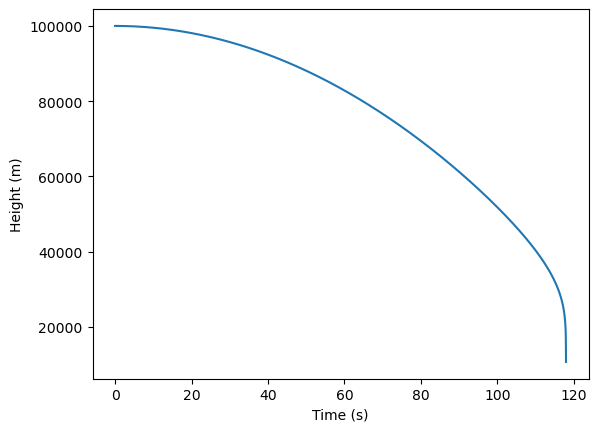

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Declaring Constants
rho_0 = 1.225  # Atmospheric density at sea level, kg/m^3
H = 8400.0  # Atmospheric pressure ratio height, m
G = 6.67430e-11  # Gravitation constant, m^3 kg^-1 s^-2
M_earth = 5.972e24  # Earth mass, kg
R_earth = 6371000  # Earth radius, m
C_d = 2.2  # Drag coefficient
m = 3000  # Satellite mass, kg
A = np.pi * (3.3 / 2)**2  # Satellite windward area, m^2

# Track parameters
apogee = 441900 + R_earth  # Apogee，441.9km + earth radius
perigee = 430000 + R_earth  # Perigee，430.0km + earth radius

# Calculate the semi-major axis and the current apogee velocity
a = (apogee + perigee) / 2
v_apogee = np.sqrt(G * M_earth * (2/apogee - 1/a))

# Defined new perigee
R_p_new = 100000 + R_earth  # New perigee，100 km + earth radius
a_new = (apogee + R_p_new) / 2

# Use vis-viva function to calculate the velocity of the recent location
v_p_new = np.sqrt(G * M_earth * (2 / R_p_new - 1 / a_new))

# Calculate Δv
delta_v = v_apogee - v_p_new

# Calculate the required force for the new delta_v
F = m * delta_v / 1

# Initial conditions
v_initial_horizontal = v_p_new  # Initial horizontal velocity, m/s
v_initial_vertical = 0  # Initial vertical velocity, m/s
h_initial = 100000  # Initial height，m
time_step = 0.01  # Timestep, s
simulation_time = 2000  # Total simulation time, s

# Initializes the speed and position array
times = np.arange(0, simulation_time, time_step)
vx = np.zeros_like(times)
vy = np.zeros_like(times)
x = np.zeros_like(times)
y = np.zeros_like(times)
a_x = np.zeros_like(times)
a_y = np.zeros_like(times)
f_x = np.zeros_like(times)
f_y = np.zeros_like(times)

vx[0] = v_initial_horizontal
vy[0] = v_initial_vertical
y[0] = R_p_new  # Total altitude = initial altitude + Earth radius
x[0] = 0
a_x[0] = 0
a_y[0] = 0
f_x[0] = 0
f_y[0] = 0

for i in range(1, len(times)):
    # Calculated atmospheric density by ρ = ρ_0 * e^-(h/H)
    rho = rho_0 * np.exp(-(y[i-1] - R_earth) / H)
    
    # Resistant index by F = 1/2 * ρ * v^2 * C_d * A
    Fd_x = 0.5 * rho * vx[i-1]**2 * C_d * A
    Fd_y = 0.5 * rho * vy[i-1]**2 * C_d * A
    f_x[i] = Fd_x
    f_y[i] = Fd_y
    
    # Calculated gravitational acceleration
    g_local = G * M_earth / y[i-1]**2
    
    # Calculated acceleration
    ax = -Fd_x / m
    ay = -g_local - Fd_y / m
    a_x[i] = ax
    a_y[i] = ay
    
    # Update velocity
    vx[i] = vx[i-1] + ax * time_step
    vy[i] = vy[i-1] + ay * time_step
    
    # Update position
    x[i] = x[i-1] + vx[i] * time_step
    y[i] = y[i-1] + vy[i] * time_step
    
    # If the altitude is less than the Earth radius, the simulation stops
    if y[i] <= R_earth:
        y[i] = R_earth
        print("Simulation stopped at index:", i)
        break

plt.plot(times[:i], y[:i] - R_earth)  
plt.xlabel('Time (s)')
plt.ylabel('Height (m)')
plt.show()